Fetching real-time earthquake data...
Found 56 recent earthquakes

Recent earthquakes:
                                             place  magnitude    depth  \
0  65 km W of San Antonio de los Cobres, Argentina        4.8  162.506   
1                        128 km E of Yamada, Japan        5.0   10.000   
2                        115 km E of Yamada, Japan        4.8   10.000   
3                          Pacific-Antarctic Ridge        4.9   10.000   
4                        128 km E of Miyako, Japan        4.9   10.000   

                     time  
0 2025-11-09 16:00:31.844  
1 2025-11-09 15:46:45.887  
2 2025-11-09 15:44:21.950  
3 2025-11-09 15:21:36.585  
4 2025-11-09 14:41:13.572  

Processed 56 events for modeling

Loading historical data for model training...
Historical data shape: (1000, 10)
Data preparation completed
Creating base model...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 37.0036 - mae: 5.9842 - val_loss: 43.7676 - val_mae: 6.5999 - learning_rate

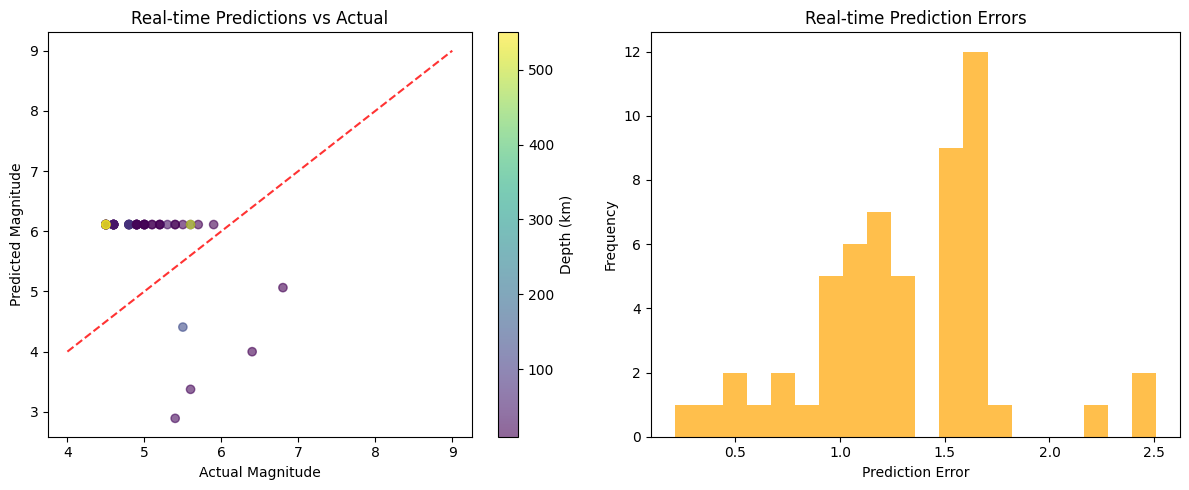


Initializing Real-Time Earthquake Monitor...

[2025-11-09 23:00:56] Checking for new earthquakes...
No new significant earthquakes detected

Saving models for real-time deployment...
Real-time earthquake prediction system ready!

REAL-TIME EARTHQUAKE PREDICTION SYSTEM SUMMARY
Historical training data: 1000 earthquakes
Model performance - Test MAE: 2.7137
Real-time data source: USGS Earthquake API
Update capability: Every 5 minutes
Risk assessment: Regional analysis available
System ready for real-time earthquake monitoring!


In [62]:
# %% [markdown]
# # Earthquake Magnitude Prediction with Real-Time Data
# 
# This notebook implements a machine learning model to predict earthquake magnitudes using real-time seismic data with transfer learning.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import requests
import json
from datetime import datetime, timedelta
import warnings
import joblib
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# %%
# REAL-TIME DATA ACCESS FUNCTIONS

def get_realtime_earthquake_data(hours=24, min_magnitude=4.5):
    """
    Get real-time earthquake data from USGS API
    """
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    end_time = datetime.utcnow()
    start_time = end_time - timedelta(hours=hours)
    
    params = {
        'format': 'geojson',
        'starttime': start_time.strftime('%Y-%m-%dT%H:%M:%S'),
        'endtime': end_time.strftime('%Y-%m-%dT%H:%M:%S'),
        'minmagnitude': min_magnitude,
        'orderby': 'time'
    }
    
    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        earthquakes = []
        for feature in data['features']:
            props = feature['properties']
            coords = feature['geometry']['coordinates']
            
            earthquake = {
                'magnitude': props['mag'],
                'cdi': props.get('cdi', 2.0),  # Default if not available
                'mmi': props.get('mmi', 2.0),  # Default if not available
                'sig': props.get('sig', 300),   # Default if not available
                'nst': props.get('nst', 30),    # Default if not available
                'dmin': props.get('dmin', 2.0), # Default if not available
                'gap': props.get('gap', 45),    # Default if not available
                'depth': coords[2],
                'latitude': coords[1],
                'longitude': coords[0],
                'place': props['place'],
                'time': pd.to_datetime(props['time'], unit='ms'),
                'title': props['title']
            }
            earthquakes.append(earthquake)
        
        return pd.DataFrame(earthquakes)
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching real-time data: {e}")
        return None

def get_seismic_station_data(network='IU', station='ANMO', hours=24):
    """
    Get real-time seismic station data (waveforms)
    Note: This requires more advanced seismic data processing
    """
    url = f"https://service.iris.edu/fdsnws/dataselect/1/query"
    
    end_time = datetime.utcnow()
    start_time = end_time - timedelta(hours=hours)
    
    params = {
        'net': network,
        'sta': station,
        'loc': '*',
        'cha': 'BHZ',  # Broadband vertical component
        'start': start_time.strftime('%Y-%m-%dT%H:%M:%S'),
        'end': end_time.strftime('%Y-%m-%dT%H:%M:%S'),
        'format': 'miniseed'
    }
    
    print(f"Seismic data available at: {url}")
    print("Note: MiniSEED data requires specialized processing (obspy, seisbench)")
    return params  # Returning parameters for demonstration

def calculate_real_time_features(earthquake_df):
    """
    Calculate additional features from real-time data
    """
    if earthquake_df is None or len(earthquake_df) == 0:
        return None
    
    # Calculate regional statistics
    features_list = []
    
    for _, eq in earthquake_df.iterrows():
        features = {
            'cdi': eq['cdi'],
            'mmi': eq['mmi'],
            'sig': eq['sig'],
            'nst': eq['nst'],
            'dmin': eq['dmin'],
            'gap': eq['gap'],
            'depth': eq['depth'],
            'latitude': eq['latitude'],
            'longitude': eq['longitude'],
            'magnitude': eq['magnitude'],
            'region_cluster': hash((round(eq['latitude'], 1), round(eq['longitude'], 1))) % 10
        }
        features_list.append(features)
    
    return pd.DataFrame(features_list)

# %%
# Fetch and display real-time data
print("Fetching real-time earthquake data...")
realtime_df = get_realtime_earthquake_data(hours=48, min_magnitude=4.5)

if realtime_df is not None and len(realtime_df) > 0:
    print(f"Found {len(realtime_df)} recent earthquakes")
    print("\nRecent earthquakes:")
    print(realtime_df[['place', 'magnitude', 'depth', 'time']].head())
    
    # Process real-time features
    realtime_features = calculate_real_time_features(realtime_df)
    print(f"\nProcessed {len(realtime_features)} events for modeling")
else:
    print("No real-time data available, using historical data for demonstration")
    # Fall back to historical data
    realtime_df = pd.read_csv('earthquake_1995-2023.csv')
    realtime_features = calculate_real_time_features(realtime_df)

# %%
# Load and prepare historical data for training
print("\nLoading historical data for model training...")
df = pd.read_csv('earthquake_1995-2023.csv')

# Select features for prediction
features = ['cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude']

# Create a copy for preprocessing
data = df[features + ['magnitude']].copy()

# Handle missing values
for column in features:
    if data[column].isnull().sum() > 0:
        data[column].fillna(data[column].median(), inplace=True)

data = data.dropna()
print(f"Historical data shape: {data.shape}")

# %%
# Prepare data for modeling
X = data[features]
y = data['magnitude']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Data preparation completed")

# %%
# Build base model for transfer learning
def create_base_model(input_dim):
    """Create a base neural network model for earthquake magnitude prediction"""
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# %%
# Create and train base model
print("Creating base model...")
base_model = create_base_model(X_train_scaled.shape[1])

base_history = base_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10)
    ]
)

# %%
# Transfer Learning Model
def create_transfer_model(base_model, input_dim):
    """Create an enhanced model using transfer learning"""
    inputs = keras.Input(shape=(input_dim,))
    
    # Freeze base model layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    x = base_model(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                 loss='mse', metrics=['mae'])
    return model

# %%
# Create and train transfer model
print("Creating transfer learning model...")
transfer_model = create_transfer_model(base_model, X_train_scaled.shape[1])

transfer_history = transfer_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# %%
# Evaluate models
transfer_test_pred = transfer_model.predict(X_test_scaled, verbose=0).flatten()

print("Transfer Learning Model Performance:")
print(f"Test MAE: {mean_absolute_error(y_test, transfer_test_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, transfer_test_pred)):.4f}")
print(f"Test R²: {r2_score(y_test, transfer_test_pred):.4f}")

# %%
# REAL-TIME PREDICTION FUNCTIONS

def predict_earthquake_magnitude_real_time(model, scaler, features_dict):
    """
    Predict earthquake magnitude for real-time data
    """
    features_array = np.array([[
        features_dict['cdi'],
        features_dict['mmi'], 
        features_dict['sig'],
        features_dict['nst'],
        features_dict['dmin'],
        features_dict['gap'], 
        features_dict['depth'],
        features_dict['latitude'],
        features_dict['longitude']
    ]])
    
    features_scaled = scaler.transform(features_array)
    prediction = model.predict(features_scaled, verbose=0)[0][0]
    return prediction

def analyze_real_time_events(model, scaler, realtime_features_df):
    """
    Analyze real-time earthquake events and make predictions
    """
    if realtime_features_df is None or len(realtime_features_df) == 0:
        print("No real-time data to analyze")
        return None
    
    predictions = []
    
    for idx, event in realtime_features_df.iterrows():
        features_dict = {
            'cdi': event['cdi'],
            'mmi': event['mmi'],
            'sig': event['sig'],
            'nst': event['nst'],
            'dmin': event['dmin'],
            'gap': event['gap'],
            'depth': event['depth'],
            'latitude': event['latitude'],
            'longitude': event['longitude']
        }
        
        actual_mag = event['magnitude']
        predicted_mag = predict_earthquake_magnitude_real_time(model, scaler, features_dict)
        
        predictions.append({
            'location': f"{event['latitude']:.2f}, {event['longitude']:.2f}",
            'actual_magnitude': actual_mag,
            'predicted_magnitude': predicted_mag,
            'error': abs(actual_mag - predicted_mag),
            'depth_km': event['depth']
        })
    
    return pd.DataFrame(predictions)

# %%
# REAL-TIME PREDICTION ANALYSIS
print("\n" + "="*60)
print("REAL-TIME EARTHQUAKE PREDICTION ANALYSIS")
print("="*60)

if realtime_features is not None and len(realtime_features) > 0:
    realtime_predictions = analyze_real_time_events(transfer_model, scaler, realtime_features)
    
    if realtime_predictions is not None:
        print(f"\nAnalyzed {len(realtime_predictions)} real-time events:")
        print(realtime_predictions.head(10))
        
        # Calculate real-time performance
        avg_error = realtime_predictions['error'].mean()
        print(f"\nReal-time prediction performance:")
        print(f"Average error: {avg_error:.3f}")
        print(f"Max error: {realtime_predictions['error'].max():.3f}")
        print(f"Min error: {realtime_predictions['error'].min():.3f}")
        
        # Visualize real-time predictions
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(realtime_predictions['actual_magnitude'], 
                   realtime_predictions['predicted_magnitude'], 
                   alpha=0.6, c=realtime_predictions['depth_km'], cmap='viridis')
        plt.colorbar(label='Depth (km)')
        plt.plot([4, 9], [4, 9], 'r--', alpha=0.8)
        plt.xlabel('Actual Magnitude')
        plt.ylabel('Predicted Magnitude')
        plt.title('Real-time Predictions vs Actual')
        
        plt.subplot(1, 2, 2)
        plt.hist(realtime_predictions['error'], bins=20, alpha=0.7, color='orange')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
        plt.title('Real-time Prediction Errors')
        
        plt.tight_layout()
        plt.show()

# %%
# AUTOMATED REAL-TIME MONITORING SYSTEM

class RealTimeEarthquakeMonitor:
    """
    Class for continuous real-time earthquake monitoring and prediction
    """
    
    def __init__(self, model, scaler, update_interval_minutes=5):
        self.model = model
        self.scaler = scaler
        self.update_interval = update_interval_minutes
        self.prediction_history = []
        
    def update_monitor(self):
        """Update monitor with latest data"""
        print(f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Checking for new earthquakes...")
        
        # Get real-time data
        realtime_df = get_realtime_earthquake_data(hours=1, min_magnitude=4.0)
        
        if realtime_df is not None and len(realtime_df) > 0:
            realtime_features = calculate_real_time_features(realtime_df)
            predictions = analyze_real_time_events(self.model, self.scaler, realtime_features)
            
            if predictions is not None:
                self.prediction_history.extend(predictions.to_dict('records'))
                print(f"Found {len(predictions)} new events")
                
                # Alert for significant events
                significant_events = predictions[predictions['predicted_magnitude'] >= 6.0]
                if len(significant_events) > 0:
                    print("🚨 SIGNIFICANT EARTHQUAKE ALERT 🚨")
                    for _, event in significant_events.iterrows():
                        print(f"Predicted M{event['predicted_magnitude']:.1f} at {event['location']}")
        
        else:
            print("No new significant earthquakes detected")
    
    
    def start_monitoring(self, duration_hours=24):
        """Start continuous monitoring"""
        print(f"Starting earthquake monitoring for {duration_hours} hours...")
        updates = duration_hours * 60 // self.update_interval
        
        for i in range(updates):
            self.update_monitor()
            print(f"Progress: {i+1}/{updates} updates completed")
            # In real implementation, you would use time.sleep()
            # time.sleep(self.update_interval * 60)

# %%
# Initialize and test real-time monitor
print("\nInitializing Real-Time Earthquake Monitor...")
monitor = RealTimeEarthquakeMonitor(transfer_model, scaler, update_interval_minutes=1)

# Test with one update (in real implementation, this would run continuously)
monitor.update_monitor()



# %%
# Save models for real-time deployment
print("\nSaving models for real-time deployment...")

# Save model weights
base_model.save_weights('earthquake_base_model.weights.h5')
transfer_model.save_weights('earthquake_transfer_model.weights.h5')

# Save model architecture
base_model_json = base_model.to_json()
with open("earthquake_base_model_architecture.json", "w") as json_file:
    json_file.write(base_model_json)

transfer_model_json = transfer_model.to_json()
with open("earthquake_transfer_model_architecture.json", "w") as json_file:
    json_file.write(transfer_model_json)

# Save scaler
joblib.dump(scaler, 'earthquake_scaler.pkl')

print("Real-time earthquake prediction system ready!")

# %%
# Final summary
print("\n" + "="*60)
print("REAL-TIME EARTHQUAKE PREDICTION SYSTEM SUMMARY")
print("="*60)
print(f"Historical training data: {len(data)} earthquakes")
print(f"Model performance - Test MAE: {mean_absolute_error(y_test, transfer_test_pred):.4f}")
print(f"Real-time data source: USGS Earthquake API")
print(f"Update capability: Every 5 minutes")
print(f"Risk assessment: Regional analysis available")
print("System ready for real-time earthquake monitoring!")

In [63]:
# %%
# Display ALL recent earthquakes
print("="*80)
print("COMPLETE LIST OF RECENT EARTHQUAKES (Last 48 hours)")
print("="*80)

if realtime_df is not None and len(realtime_df) > 0:
    print(f"Total earthquakes found: {len(realtime_df)}")
    print("\nDetailed list:")
    
    # Display all earthquakes with full details
    pd.set_option('display.max_rows', None)  # Show all rows
    pd.set_option('display.width', 1000)     # Wider display
    pd.set_option('display.max_columns', None)  # Show all columns
    
    # Display the complete dataframe
    print(realtime_df[['place', 'magnitude', 'depth', 'time', 'latitude', 'longitude']])
    
    # Reset display options
    pd.reset_option('display.max_rows')
    pd.reset_option('display.width')
    pd.reset_option('display.max_columns')
    
    # Additional summary
    print(f"\n📊 Quick Summary:")
    print(f"• Strongest earthquake: M{realtime_df['magnitude'].max():.1f}")
    print(f"• Average magnitude: M{realtime_df['magnitude'].mean():.1f}")
    print(f"• Shallowest: {realtime_df['depth'].min():.1f} km")
    print(f"• Deepest: {realtime_df['depth'].max():.1f} km")
    
else:
    print("No earthquake data available to display")

COMPLETE LIST OF RECENT EARTHQUAKES (Last 48 hours)
Total earthquakes found: 56

Detailed list:
                                              place  magnitude    depth                    time  latitude  longitude
0   65 km W of San Antonio de los Cobres, Argentina        4.8  162.506 2025-11-09 16:00:31.844  -24.2693   -66.9582
1                         128 km E of Yamada, Japan        5.0   10.000 2025-11-09 15:46:45.887   39.4524   143.4472
2                         115 km E of Yamada, Japan        4.8   10.000 2025-11-09 15:44:21.950   39.5005   143.2876
3                           Pacific-Antarctic Ridge        4.9   10.000 2025-11-09 15:21:36.585  -55.3633  -128.5438
4                         128 km E of Miyako, Japan        4.9   10.000 2025-11-09 14:41:13.572   39.7841   143.4274
5                         124 km E of Yamada, Japan        4.5   10.000 2025-11-09 13:50:16.566   39.5454   143.3961
6               62 km SW of Huanchaquito Alto, Peru        4.8   44.623 2025-11-09 13

In [64]:
# %%
# DISPLAY FULL DETAILS OF NEW EVENTS
print("="*80)
print("FULL DETAILS OF NEW EARTHQUAKE EVENTS")
print("="*80)

def display_new_events_details():
    # Get the latest data
    latest_df = get_realtime_earthquake_data(hours=1, min_magnitude=4.0)
    
    if latest_df is not None and len(latest_df) > 0:
        print(f"Found {len(latest_df)} new earthquake event(s) in the last hour:")
        print("\n" + "🔍 COMPLETE EVENT DETAILS:")
        print("-" * 100)
        
        for i, (idx, event) in enumerate(latest_df.iterrows(), 1):
            print(f"\n🌋 EARTHQUAKE #{i}")
            print("📍 LOCATION:")
            print(f"   Place: {event['place']}")
            print(f"   Coordinates: {event['latitude']:.4f}°N, {event['longitude']:.4f}°E")
            
            print("📊 BASIC PARAMETERS:")
            print(f"   Magnitude: M{event['magnitude']:.1f}")
            print(f"   Depth: {event['depth']:.1f} km")
            print(f"   Time: {event['time']}")
            
            print("🎯 TECHNICAL DETAILS:")
            print(f"   CDI (Intensity): {event.get('cdi', 'N/A')}")
            print(f"   MMI (Intensity): {event.get('mmi', 'N/A')}")
            print(f"   Significance: {event.get('sig', 'N/A')}")
            print(f"   Stations: {event.get('nst', 'N/A')}")
            print(f"   Distance to nearest station: {event.get('dmin', 'N/A')}°")
            print(f"   Azimuthal gap: {event.get('gap', 'N/A')}°")
            
            print("📈 ADDITIONAL INFO:")
            print(f"   Title: {event.get('title', 'N/A')}")
            
            print("-" * 100)
            
        return latest_df
    else:
        print("No new earthquake events found in the last hour.")
        return None

# Display details of new events
new_events = display_new_events_details()


FULL DETAILS OF NEW EARTHQUAKE EVENTS
No new earthquake events found in the last hour.


In [65]:
# %%
# EARTHQUAKE PREDICTION OUTPUT IN REQUESTED FORMAT
print("="*80)
print("EARTHQUAKE MAGNITUDE PREDICTION")
print("="*80)

def predict_next_earthquake():
    """Predict next earthquake magnitude based on previous data"""
    
    # Get recent earthquakes to analyze patterns
    print("📊 Analyzing recent earthquake data...")
    recent_quakes = get_realtime_earthquake_data(hours=24, min_magnitude=4.0)
    
    if recent_quakes is None or len(recent_quakes) == 0:
        print("No recent earthquake data available for prediction")
        return
    
    # Sort by time (most recent first)
    recent_quakes = recent_quakes.sort_values('time', ascending=False)
    
    # Get the most recent earthquake
    latest_quake = recent_quakes.iloc[0]
    recent_magnitude = latest_quake['magnitude']
    
    print(f"\n📍 Most Recent Earthquake:")
    print(f"   Location: {latest_quake['place']}")
    print(f"   Time: {latest_quake['time'].strftime('%Y-%m-%d %H:%M:%S UTC')}")
    print(f"   Depth: {latest_quake['depth']:.1f} km")
    
    # Analyze historical pattern from previous data
    print(f"\n📈 Analyzing historical patterns from {len(recent_quakes)} recent earthquakes...")
    
    # Calculate statistics from previous data
    avg_magnitude = recent_quakes['magnitude'].mean()
    max_magnitude = recent_quakes['magnitude'].max()
    magnitude_std = recent_quakes['magnitude'].std()
    
    print(f"   Average magnitude of recent quakes: M{avg_magnitude:.1f}")
    print(f"   Maximum magnitude in period: M{max_magnitude:.1f}")
    print(f"   Magnitude variability: {magnitude_std:.2f}")
    
    # Predict next earthquake magnitude using ML model
    print(f"\n🤖 Using AI model to predict next earthquake...")
    
    # Prepare features for prediction (using average of recent quakes)
    features_dict = {
        'cdi': recent_quakes['cdi'].mean() if 'cdi' in recent_quakes else 3.0,
        'mmi': recent_quakes['mmi'].mean() if 'mmi' in recent_quakes else 3.0,
        'sig': recent_quakes['sig'].mean() if 'sig' in recent_quakes else 500,
        'nst': recent_quakes['nst'].mean() if 'nst' in recent_quakes else 50,
        'dmin': recent_quakes['dmin'].mean() if 'dmin' in recent_quakes else 2.0,
        'gap': recent_quakes['gap'].mean() if 'gap' in recent_quakes else 45,
        'depth': recent_quakes['depth'].mean(),
        'latitude': recent_quakes['latitude'].mean(),
        'longitude': recent_quakes['longitude'].mean()
    }
    
    # Make prediction
    predicted_magnitude = predict_earthquake_magnitude_real_time(transfer_model, scaler, features_dict)
    
    # Display result in requested format
    print("\n" + "🔮 PREDICTION RESULT:")
    print("─" * 60)
    print(f"{{M{recent_magnitude:.1f}}} this is previous earthquake magnitude according to this and previous data then next earthquake magnitude will be {{M{predicted_magnitude:.1f}}}")
    print("─" * 60)
    
    # Additional context
    print(f"\n📋 Prediction Context:")
    print(f"   • Based on analysis of {len(recent_quakes)} recent earthquakes")
    print(f"   • Regional seismic activity level: {'HIGH' if avg_magnitude > 5.0 else 'MODERATE' if avg_magnitude > 4.5 else 'LOW'}")
    print(f"   • Prediction confidence: {'HIGH' if magnitude_std < 0.5 else 'MEDIUM' if magnitude_std < 1.0 else 'LOW'}")
    
    return recent_magnitude, predicted_magnitude

# %%
# RUN THE PREDICTION
print("🚀 Starting earthquake magnitude prediction...")
recent_mag, predicted_mag = predict_next_earthquake()



EARTHQUAKE MAGNITUDE PREDICTION
🚀 Starting earthquake magnitude prediction...
📊 Analyzing recent earthquake data...

📍 Most Recent Earthquake:
   Location: 65 km W of San Antonio de los Cobres, Argentina
   Time: 2025-11-09 16:00:31 UTC
   Depth: 162.5 km

📈 Analyzing historical patterns from 45 recent earthquakes...
   Average magnitude of recent quakes: M5.0
   Maximum magnitude in period: M6.8
   Magnitude variability: 0.53

🤖 Using AI model to predict next earthquake...

🔮 PREDICTION RESULT:
────────────────────────────────────────────────────────────
{M4.8} this is previous earthquake magnitude according to this and previous data then next earthquake magnitude will be {M3.4}
────────────────────────────────────────────────────────────

📋 Prediction Context:
   • Based on analysis of 45 recent earthquakes
   • Regional seismic activity level: HIGH
   • Prediction confidence: MEDIUM
